# Meta'omics for Ocean Science

Ocean Hack Week 2023 Tutorial by Julia M Brown

![scales](./tutorial_images/rainbow_satellite_to_microbe.png)  

With thanks to the following for content and inspiration:  
[Greg Gavelis](https://github.com/ggavelis), [Joe Brown](https://github.com/brwnj), [Maria Pachiadaki](https://github.com/microbiaki), [Ramunas Stepanauskas](https://www.bigelow.org/about/people/rstepanauskas.html), [MerenLab](https://merenlab.org/), [Kaiju Team](https://bioinformatics-centre.github.io/kaiju/), [Cath Mitchell](https://github.com/MarineOpticsLab)



### What is 'omics data?

* Data on biological molecules  
* 'Meta' refers to collecting and processing samples in bulk 
* Data often focused on specific size fractions  

### How is it generated?

* Collection of sample in bulk.  
* For planktonic microbes, samples are collected based on a specific size fraction that targets different microbial groups
    * e.g. bacteria and archaea, protists, phytoplankton, viruses  
* Nucleic acids, proteins or other target molecules extracted and sequenced 
* For nucleotide data (DNA + RNA), samples often sequenced via Illumina sequencing
    * generates short __paired end__ reads 
    * reads can be characterized directly or used to assemble larger __contiguous sequences__

![omics](./tutorial_images/metaXomics_diagram.png)  

### It can tell us the who and what of microbial communities

**Metagenome (DNA)** : Presence and potential  
**Metatranscriptome (RNA)**: Activity  

**Taxonomy:**  

* What microbes are present -- DNA
* Which microbes are active -- RNA

**Function:**

* What is the metabolic potential? -- DNA
* What processes are being carried out? -- RNA

### What does it look like?  

* fastq - raw sequence read data with quality information included
* fasta - sequence data, can be contiguous sequences, open reading frames (i.e. coding sequences) or protein sequences



### How can we use raw reads?

**Read profiling** is one of the most commonly used processes in 'omics analysis. It is applied to access the relative abundance of taxonomic groups within metagenomic datasets (when using DNA metagenomes) or to estimate the expression of different microbial taxa (when RNA metatranscriptomes are used).

In a nutshell short reads are aligned to a genomic reference sequences, which have taxonomic information assigned to them that may be assigned to the reads.

![recruitment](./tutorial_images/01-metagenomic-read-recruitment-simple.gif)  
(Thank you [MerenLab](https://merenlab.org/) for the animation)

# Read classification tools

# [Kaiju](https://kaiju.binf.ku.dk/server)
![Kaiju](https://kaiju.binf.ku.dk/images/kaiju3_header.gif)

**Also: [Kraken2](https://github.com/DerrickWood/kraken2/)**

These workflows are wicked fast!

### How do they work?

**Database**  
Database consists of a collection of translated proteins mapped to microbial genomes.

<img src="./tutorial_images/proteins_to_genomes.png" alt="p2g" width="400"/>

### Short read alignment

Reads are translated into protein sequences and aligned to reference protein sequences. Best matches to proteins are then taxonomically assigned based on protein's membership in microbial genomes.

![kaiju_diagram](./tutorial_images/short_read_align.png)

## Tools are as good as your reference database

Kaiju and other classifiers rely on genome databases that primarily contain genomes from isolated microbes and genomes assembled from metagenomes ('MAGs').

**Available Standard Kaiju Databases**  
<img src="https://upload.wikimedia.org/wikipedia/commons/0/07/US-NLM-NCBI-Logo.svg" alt="ncbi" width="100"/>

**nr**: Non-redundant proteins from bacteria, archaea and viruses  
**RefSeq**: Curated bacterial, archaeal and viral genomes from NCBI

<img src="https://progenomes.embl.de/img/progene_head21.png" alt="progenomes" width="300"/>  

**ProGenomes**: Database of microbial genomes including MAGs from diverse environments

**Note:** Kaiju has other available databases that could be useful for your environment or organisms of interest. See their website for more options.  

**Database Limitations**: Despite the depth of these collections, they leave stones unturned. Microbial genomic diversity is high in marine systems and genomes assembled from short reads represent only a fraction of the microbial diversity present in the ocean!

## SAGs

Single Cell Genomics is another type of 'omics data that is well suited for reference genomic data. It consists of DNA sequence data generated from the DNA present in single cells.  Each set of data from each cell is referred to as a __Single Amplified Genome (i.e. SAG)__. SAGs represent real biological units recovered from samples, and contain genomic information specific to individuals.

<img src="./tutorial_images/scg_diagram.png" alt="sag" width="600"/>

## GORG-Tropics: A collection of reference genomes from individual cells from the Tropical and Sub-tropical Epipelagic Ocean

GORG-Tropics is more representative of global ocean microbes than MAGs or currently available reference genomes*.

*I am not sure if GORG-Tropics has been integrated into ProGenomes or not

![GORG-Figure2](https://ars.els-cdn.com/content/image/1-s2.0-S0092867419312735-gr2.jpg)  


GORG-Tropics is more accurate and sensitive than default databases used for read classification by Kaiju when analyzing marine epipelagic samples. When GORG-Tropics used as a database for reads from similar environments, many more were able to be correctly classified. 

![GORG-Figure](https://ars.els-cdn.com/content/image/1-s2.0-S0092867419312735-gr6.jpg)  

The other advantage of using a tailored database is that it takes up less storage space :)

The Project data can be found [here](https://osf.io/pcwj9/).

Specific database files used for this tutorial are:  
[GORG_v1_CREST.fmi](https://osf.io/a3428)  
[nodes.dmp](https://osf.io/a8bm5)  
[names.dmp](https://osf.io/cqrh4)  

Note that I am going to show you this workflow in steps using kaiju, BUT the entire kaiju workflow using the GORG-Tropics database is packaged into a docker/singularity container and can be run with nextflow, seen here:[GORG-Classifier](https://github.com/BigelowLab/gorg-classifier).

## Data Prep

We will be running Kaiju on a collection of epipelagic metagenomes from the Bermuda Atlantic Time Series using version 1 of the GORG-Tropics database.


For this lesson, we look at microbial community dynamics over time at BATs using short read alignment with Kaiju against the GORG-Tropics database.

The metagenomes we will use are a small subset of metagenomes reported in [this](https://www.nature.com/articles/sdata2018176) publication. These metagenomes are available in NCBI's Short Read Archive (sra) through NCBI project ID [PRJNA385855](https://www.ncbi.nlm.nih.gov/bioproject?term=PRJNA385855). I've downloaded a metadata sheet with all sra metagenomes from this bioproject to: ./data/PRJNA385855_sra_metadata.csv

Let's check this table out, and I'll show you which metagenomes I selected.

In [25]:
import pandas as pd

df = pd.read_csv("./data/PRJNA385855_sra_metadata.csv", sep = ",")

df.head()

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,BioSampleModel,bottle_id,Bytes,Center Name,...,lat_lon,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,Sample Name,SRA Study
0,SRR6507277,WGS,300,16133582100,PRJNA385855,SAMN08390922,"MIMS.me,MIGS/MIMS/MIMARKS.water",2140200308,6618578156,MIT,...,22.75 N 158 W,S0627,PAIRED,RANDOM,METAGENOMIC,marine metagenome,ILLUMINA,2018-05-01T00:00:00Z,S0627,SRP109831
1,SRR6507278,WGS,300,15874959000,PRJNA385855,SAMN08390923,"MIMS.me,MIGS/MIMS/MIMARKS.water",2160200304,6562862443,MIT,...,22.75 N 158 W,S0628,PAIRED,RANDOM,METAGENOMIC,marine metagenome,ILLUMINA,2018-05-01T00:00:00Z,S0628,SRP109831
2,SRR6507279,WGS,300,15069825300,PRJNA385855,SAMN08390924,"MIMS.me,MIGS/MIMS/MIMARKS.water",1024800503,6265839401,MIT,...,31.66 N 64.16 W,S0629,PAIRED,RANDOM,METAGENOMIC,marine metagenome,ILLUMINA,2018-05-01T00:00:00Z,S0629,SRP109831
3,SRR6507280,WGS,300,25807308000,PRJNA385855,SAMN08390925,"MIMS.me,MIGS/MIMS/MIMARKS.water",1025200510,10523504402,MIT,...,31.66 N 64.16 W,S0630,PAIRED,RANDOM,METAGENOMIC,marine metagenome,ILLUMINA,2018-05-01T00:00:00Z,S0630,SRP109831
4,SRR5720219,WGS,300,6713331000,PRJNA385855,SAMN07137016,"MIMS.me,MIGS/MIMS/MIMARKS.water",1640201117,2811014041,MIT,...,22.75 N 158 W,S0519,PAIRED,RANDOM,METAGENOMIC,marine metagenome,ILLUMINA,2018-05-01T00:00:00Z,S0519,SRP109831


There's a lot of information here, for now, we just need the 'Run' ID so that we can use it to grab data from NCBI, as well as the collection date and depth.

In [26]:
# selecting surface samples collected from BATS
surface_bats = df[df['cruise_id'].str.contains('BATS') & df['Depth'].isin(['10m','1m'])][['Run','Collection_date','cruise_id','BioSample','Depth']].sort_values(by = 'Collection_date')

print('There are', len(surface_bats), 'metagenomes')
surface_bats

There are 21 metagenomes


,Run,Collection_date,cruise_id,BioSample,Depth
74,SRR5720233,2003-02-21,BATS173,SAMN07137079,1m
14,SRR5720238,2003-03-22,BATS174,SAMN07137082,1m
119,SRR5720327,2003-04-22,BATS175,SAMN07137064,10m
99,SRR5720283,2003-05-20,BATS176,SAMN07137103,1m
75,SRR5720235,2003-07-15,BATS178,SAMN07137085,10m
38,SRR5720286,2003-08-12,BATS179,SAMN07137088,10m
64,SRR5720332,2003-10-07,BATS181,SAMN07137067,1m
96,SRR5720276,2003-11-04,BATS182,SAMN07137106,1m
90,SRR5720262,2003-12-02,BATS183,SAMN07137109,1m
124,SRR5720338,2004-01-27,BATS184,SAMN07137070,1m


Let's just focus on one year to make things simple.


In [27]:
# grab only samples from 2004
# naming it mgoi for 'metagenomes of interest'
mgoi = surface_bats[surface_bats['Collection_date'].str.contains('2004')]
len(mgoi)

11

In [28]:
# going to save this table to file
mgoi.to_csv("./data/bats_metagenomes_of_interest.csv", index=False)

# I also saved a text file with one metagenome ID per line for downloading these metagenomes with a shell script
with open('data/metagenomes_to_download.txt', 'w') as oh:
    for run in mgoi['Run']:
        print(run, file = oh)

I next downloaded these metagenomes from NCBI using a package called [fastq-dl](https://github.com/rpetit3/fastq-dl). These metagenomes are large, and downloading them takes a while, so I did this overnight using a small shell script:

```
cd ./data/

while read p; 
    do fastq-dl -a $p --provider sra; 
done < metagenomes_to_download.txt
```

Then, for the purposes of this tutorial, I subsampled these paired metagenomes down to 100000k reads per metagenome using a package called [seqtk](https://github.com/lh3/seqtk). I was lazy and ran this in a jupyter notebook. The script I used to do this was:

```
%%python
import glob

ffqs = glob.glob("*_1.fastq.gz")

for f in ffqs:
    r = f.replace('_1','_2')
    
    outf = "./subsampled_metagenomes/{}".format(f.replace("_1.fastq.gz",
                                                          '_100ksub_1.fastq.gz'))
    outr = "./subsampled_metagenomes/{}".format(r.replace("_2.fastq.gz",
                                                          '_100ksub_2.fastq.gz'))
    
    !seqtk sample -s 123 {f} 100000 > {outf}
    
    !seqtk sample -s 123 {r} 100000 > {outr}
```

The important command is ```seqtk sample -s 123 {infastq} 100000 > {outfastq}```.  The script randomly subsamples a subset of reads. I needed to do this for paired metagenomic data, so to make sure the samples were random but consistent between the paired files I used the ```-s``` parameter to set the seed for random sampling. After the ```-s``` parameter (which can be any integer), I provide the input fastq file and then the number of reads I would like to subsample from the input file, I then send the output to a new file. 

This step also takes a while to run, so we will be not doing this in real time. The output files from this step can be found at: XXXXXXX

### Running Kaiju

This happens in two steps. In the first step the reads are mapped to the database, and in the second step, taxonomy is assigned to each read based on how they mapped.  

Note: The first step takes much longer than the second.

Let's run this for an example genome, using only 10k reads:

In [7]:
import os.path as op

database_nodes = '../database/nodes.dmp'
database_names = '../database/names.dmp'
database = '../database/GORG_v1_CREST.fmi'
fq1 = 'data/10k_subsampled_metagenomes/SRR5720233_10ksub_1.fastq.gz'
fq2 = fq1.replace("_1.tar.gz", "_2.tar.gz")
out = op.join('outputs',op.basename(fq1).replace('_1.fastq.gz','_vs_GORGv1_kaiju.out'))
out_tax = out.replace('.out','_wtaxonomy.out')



In [127]:
!kaiju -t {database_nodes} \
-f {database} \
-i {fq1} \
-j {fq2} \
-o {out}

!kaiju-addTaxonNames -t {database_nodes} \
-n {database_names} \
-i {out} \
-o {out_tax} \
-r superkingdom,phylum,class,order,family,genus,species

Let's look at the results

In [8]:
import os.path as op

out = op.join('outputs',op.basename(fq1).replace('_1.fastq.gz','_vs_GORGv1_kaiju.out'))
out_tax = out.replace('.out','_wtaxonomy.out')


odf = pd.read_csv(out_tax, 
                  sep = "\t", 
                  names = ['status','read_id','tax_id','taxonomy'])

odf.head()

,status,read_id,tax_id,taxonomy
0,U,SRR5720233.13354180,0,NaN
1,U,SRR5720233.14562609,0,NaN
2,C,SRR5720233.3034975,2409,Bacteria; Actinobacteria; Acidimicrobiia; Acid...
3,U,SRR5720233.6694984,0,NaN
4,U,SRR5720233.8345114,0,NaN


The ouput table has four columns:  

> **status**: whether the read was classified (C) or unclassified (U)  
> **read_id**: ID of the mapped read  
> **tax_id**: taxonomic ID of mapped read  
> **taxonomy**: taxonomy of mapped read

How many reads were classified?

In [9]:
print(round(odf['status'].value_counts()['C'] / 10000 * 100, 1), 
      'percent of reads were able to be classified.')

27.5 percent of reads were able to be classified.


What did those classifications look like?

Next, let's split taxonomy column into different taxonomic levels.  
(notice that the taxonomic string used is the same as what we entered when we ran ```kaiju-addTaxonNames```)

In [11]:
def get_rank(t, index_val):
    if type(t) is str:
        return t.split(';')[index_val].lstrip()
    else:
        return t
        
for j, rank in enumerate('superkingdom,phylum,class,order,family,genus,species'.split(',')):
    odf[rank] = odf['taxonomy'].apply(lambda t: (get_rank(t, j)))

    
odf = odf.fillna('no assignment')
odf.head()

,status,read_id,tax_id,taxonomy,superkingdom,phylum,class,order,family,genus,species
0,U,SRR5720233.13354180,0,no assignment,no assignment,no assignment,no assignment,no assignment,no assignment,no assignment,no assignment
1,U,SRR5720233.14562609,0,no assignment,no assignment,no assignment,no assignment,no assignment,no assignment,no assignment,no assignment
2,C,SRR5720233.3034975,2409,Bacteria; Actinobacteria; Acidimicrobiia; Acid...,Bacteria,Actinobacteria,Acidimicrobiia,Acidimicrobiales,OM1 clade,Candidatus Actinomarina,NA
3,U,SRR5720233.6694984,0,no assignment,no assignment,no assignment,no assignment,no assignment,no assignment,no assignment,no assignment
4,U,SRR5720233.8345114,0,no assignment,no assignment,no assignment,no assignment,no assignment,no assignment,no assignment,no assignment


Now let's visualize the distribution of reads by 'Phylum' for this sample:

Text(0.5, 0, 'reads_matched')

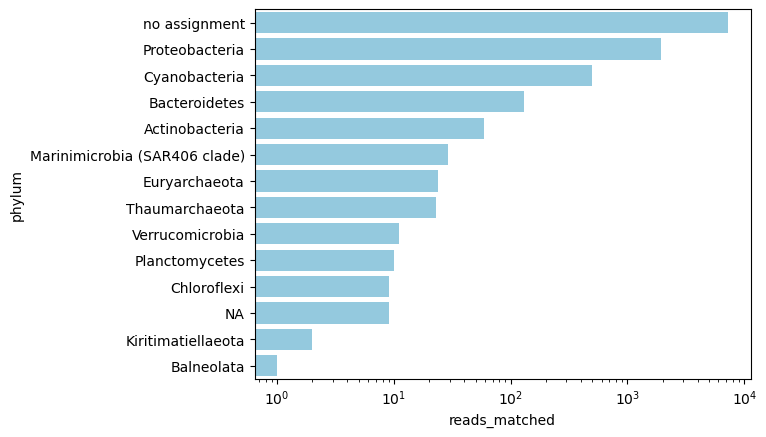

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

tax_level = 'phylum'

phycount = odf.groupby(tax_level, as_index = False)['read_id'].count().sort_values(by = 'read_id', ascending = False)
#tax_level = 'family'
#phycount = odf[odf['order'] == 'SAR11 clade'].groupby(tax_level, as_index = False)['read_id'].count().sort_values(by = 'read_id', ascending = False)

sns.barplot(x = phycount['read_id'], y = phycount[tax_level], color = 'skyblue')
plt.xscale('log')
plt.xlabel('reads_matched')

Now let's check out the whole series of samples from 2004.

In [14]:
import glob

outs = glob.glob('outputs/results/*.out')
outs

['outputs/results/SRR5720251_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 'outputs/results/SRR5720338_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 'outputs/results/SRR5720278_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 'outputs/results/SRR5720257_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 'outputs/results/SRR5720256_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 'outputs/results/SRR5720321_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 'outputs/results/SRR5720322_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 'outputs/results/SRR5720342_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 'outputs/results/SRR5720260_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 'outputs/results/SRR5720337_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 'outputs/results/SRR5720307_100ksub_vs_GORGv1_kaiju_wtaxonomy.out']

In [34]:
def read_in_kaiju(outfile):
    library = op.basename(outfile).split("_")[0]
    df = pd.read_csv(outfile, 
                  sep = "\t", 
                  names = ['status','read_id','tax_id','taxonomy'])
    df['library'] = library
    for j, rank in enumerate('superkingdom,phylum,class,order,family,genus,species'.split(',')):
        df[rank] = df['taxonomy'].apply(lambda t: (get_rank(t, j)))
    df = df.fillna('no assignment')
    return df

tax_level = 'phylum'

combodf = pd.DataFrame()

for o in outs:
    df = read_in_kaiju(o)
    phycount = df.groupby(['library',tax_level], as_index = False)['read_id'].count()
    combodf = pd.concat([combodf, phycount])

Add sample information to dataframe

In [64]:
# Load sample information and pull out 'month' value for plotting

mg_metadata = pd.read_csv('data/bats_metagenomes_of_interest.csv')
mg_metadata[['year','month','day']] = mg_metadata['Collection_date'].str.split("-", expand = True)

mg_metadata['month'] = mg_metadata['month'].apply(pd.to_numeric)

# merging metadata table with the combined phylum counts

combodf = combodf.merge(mg_metadata, left_on = 'library', right_on = 'Run', how = 'left')

Text(0, 0.5, 'Reads Assigned to Phylum')

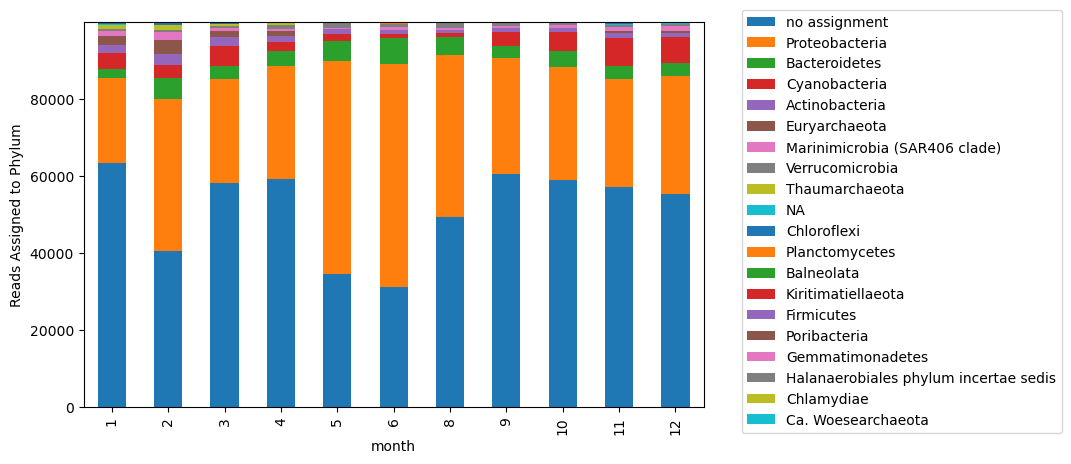

In [78]:
to_plot = combodf.groupby(['month','phylum'], as_index = False)['read_id'].sum().pivot(index = 'month', columns = 'phylum', values = 'read_id')

fig, ax = plt.subplots(figsize=(8,5))

# generating a list of phyla, ordered by abundance
column_order = list(combodf.groupby('phylum',as_index = False)['read_id'].sum().sort_values(by = 'read_id', ascending = False)['phylum'])

# ordering columns by abundance of different phyla
to_plot[column_order].plot.bar(stacked = True, ax = ax)
plt.legend(bbox_to_anchor=(1.05, 1.05))
ax.set_ylabel('Reads Assigned to Phylum')

This is perhaps not helpful?  Too many taxa are included that are not well represented in the plot. Instead, let's identify the most represented taxa.

In [79]:
# identifying the top phyla to plot

total_phycounts = combodf.groupby('phylum',as_index = False)['read_id'].sum()
top_phyla = list(total_phycounts[total_phycounts['read_id'] > 5000].sort_values(by = 'read_id', ascending = False)['phylum'])

# add column labelling top phyla and calling all others 'Other'
combodf['plot_phyla'] = [i if i in top_phyla else 'Other' for i in combodf['phylum']]

Text(0, 0.5, 'Reads Assigned to Phylum')

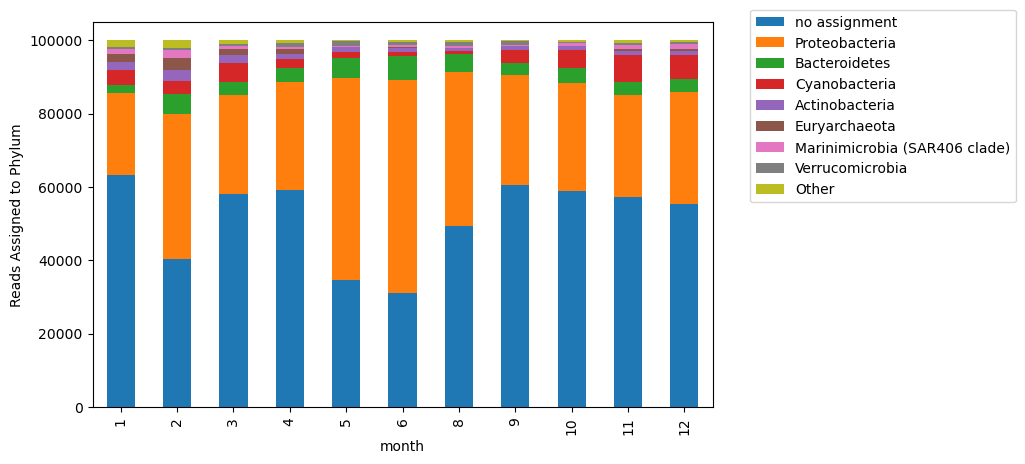

In [80]:
# group data by month and this new category, and create a pivot table for plotting
to_plot = combodf.groupby(['month','plot_phyla'], as_index = False)['read_id'].sum().pivot(index = 'month', columns = 'plot_phyla', values = 'read_id')

fig, ax = plt.subplots(figsize=(8,5))

column_order = top_phyla + ['Other']

to_plot[column_order].plot.bar(stacked = True, ax = ax)
plt.legend(bbox_to_anchor=(1.05, 1.05))
ax.set_ylabel('Reads Assigned to Phylum')


This essentially looks the same, but now our legend isn't crowded with all of the taxa present at low abundances in our samples.

Another way that this type of data is looked at is by relative abundance of only reads assigned a taxonomy, but beware that this can show totally different distributions!

Text(0, 0.5, 'Proportion Assigned Reads')

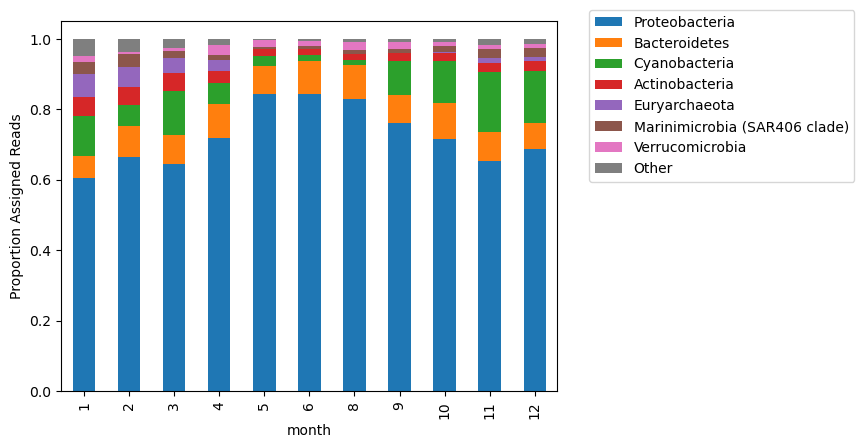

In [76]:
# remove the 'no assignment' column and calculate relative abundance of assigned reads only
tp_pct = to_plot.drop(columns = 'no assignment').div(to_plot.drop(columns = 'no assignment').sum(axis = 1), axis = 0)

# plot
tp_pct[column_order[1:]].plot.bar(stacked = True)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.ylabel('Proportion Assigned Reads')

Let's look at how Proteobacterial abundance looks based on these two different visualizations.

Text(0.5, 0, 'Month')

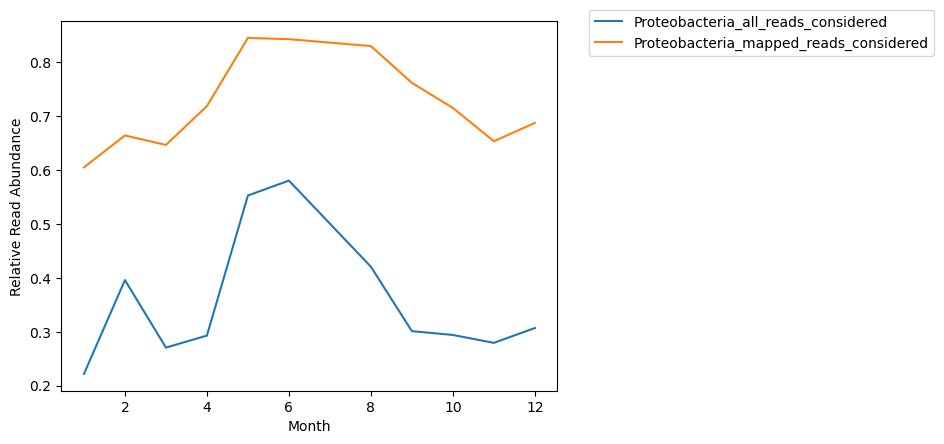

In [95]:
compdf = to_plot[['Proteobacteria']].copy().rename(columns = {'Proteobacteria':'Proteobacteria_all_reads_considered'})
compdf['Proteobacteria_all_reads_considered'] = compdf['Proteobacteria_all_reads_considered'] / 100000
compdf = compdf.merge(tp_pct[['Proteobacteria']].rename(columns = {'Proteobacteria':'Proteobacteria_mapped_reads_considered'}), 
                      left_index = True, right_index = True)
compdf.plot()
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.ylabel('Relative Read Abundance')
plt.xlabel('Month')